# Optimization of Short-Term Rental Pricing Strategy in Florence

Owners of short-term rental properties face the challenge of adjusting prices to dynamically changing market conditions. Prices should not only reflect the characteristics of a particular neighborhood but also account for seasonal fluctuations in demand.

The goal of this analysis is to determine the optimal price level that—taking into account the price elasticity of demand, location, and month of the year—maximizes both the number of bookings and total revenue throughout the year.

## Part I

A client who owns several short-term rental properties in Florence is seeking an optimal pricing strategy that will maximize revenue.

Specifically, the client is interested in forecasting revenue under scenarios where prices are reduced by 5%, 10%, 15%, and 20% compared to competitors, as well as when prices are increased by the same percentages.

The objective of this analysis is to answer the question: What rental prices maximize bookings and revenue?
The analysis is based on data from the Airbnb platform.

## Step 1: Loading data from file

In [6]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

In [8]:
listings_df = pd.read_csv("listings.csv")
listings_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,31840,A Residenza Martin Classic room,380378,Andrea,NaN,Centro Storico,43.77709,11.25216,Private room,103.0,1,148,2025-02-27,0.83,29,348,20,IT048017B4R5K5BW8E
1,32180,Charming Gem - Oltrarno City centre,13925330,Cesare,NaN,Centro Storico,43.76832,11.24348,Entire home/apt,148.0,6,38,2025-03-08,0.21,1,1,5,IT048017C232S8WUEN
2,39115,Central Double Shared Bathroom,167739,Lorenzo,NaN,Centro Storico,43.77525,11.25258,Private room,53.0,2,83,2025-03-01,0.47,10,323,7,IT048017B9LED47MUB
3,39165,Florence Central Double Private Bathroom,167739,Lorenzo,NaN,Centro Storico,43.77525,11.25258,Private room,70.0,2,23,2024-09-26,0.13,10,284,3,IT048017B9LED47MUB
4,39822,Apartment Santa Monaca Oltrarno old town,154769,Matilde,NaN,Centro Storico,43.76742,11.24378,Entire home/apt,82.0,4,32,2024-10-15,0.18,3,233,3,IT048017C2VVSRW6CW


In [10]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12477 entries, 0 to 12476
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              12477 non-null  int64  
 1   name                            12477 non-null  object 
 2   host_id                         12477 non-null  int64  
 3   host_name                       12477 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   12477 non-null  object 
 6   latitude                        12477 non-null  float64
 7   longitude                       12477 non-null  float64
 8   room_type                       12477 non-null  object 
 9   price                           11237 non-null  float64
 10  minimum_nights                  12477 non-null  int64  
 11  number_of_reviews               12477 non-null  int64  
 12  last_review                     

In [12]:
listings_df.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,1.247700e+04,1.247700e+04,0.0,12477.000000,12477.000000,11237.000000,12477.00000,12477.000000,10903.000000,12477.000000,12477.000000,12477.000000
mean,5.711467e+17,1.918823e+08,NaN,43.774195,11.253417,233.426448,5.21207,72.529053,1.808865,19.307606,191.217119,17.774545
std,5.335772e+17,2.049489e+08,NaN,0.009567,0.016536,863.701638,15.70347,112.310485,1.661312,45.858897,109.459912,21.239676
min,3.184000e+04,1.565100e+04,NaN,43.729135,11.157921,8.000000,1.00000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,2.850512e+07,2.390487e+07,NaN,43.768697,11.245266,83.000000,1.00000,4.000000,0.490000,1.000000,106.000000,1.000000
50%,6.840862e+17,9.540214e+07,NaN,43.772584,11.254210,113.000000,2.00000,27.000000,1.330000,3.000000,206.000000,9.000000
75%,1.086884e+18,3.640290e+08,NaN,43.778320,11.261620,173.000000,3.00000,90.000000,2.710000,11.000000,281.000000,29.000000
max,1.376154e+18,6.840357e+08,NaN,43.830430,11.335080,44848.000000,365.00000,1155.000000,14.350000,259.000000,365.000000,150.000000


## Step 2: Data preparation

To build the model, we will use the columns **`price`** and **`number_of_reviews`**.  
The latter will serve as a proxy for estimating the number of bookings — not every guest leaves a review, but a higher number of reviews usually indicates more reservations.

In [16]:
# Creating a new DataFrame containing only the columns `price` and `number_of_reviews`
df1 = listings_df[['price', 'number_of_reviews']]
df1

,price,number_of_reviews
0,103.0,148
1,148.0,38
2,53.0,83
3,70.0,23
4,82.0,32
...,...,...
12472,80.0,0
12473,480.0,0
12474,460.0,0
12475,122.0,0


In [18]:
# Checking for missing values in the selected columns
missing_values = df1[['price', 'number_of_reviews']].isnull().sum()

missing_values

price                1240
number_of_reviews       0
dtype: int64

The analysis shows that the **`price`** column has 1,240 missing values, while the **`number_of_reviews`** column contains no missing data.  
The missing values in the **`price`** column will be replaced with the median of the existing values in that column.


In [21]:
median_price = df1['price'].median()
df1.loc[:, 'price'] = df1['price'].fillna(median_price)

missing_values_after = df1['price'].isnull().sum()
missing_values_after

0

## Step 3: Defining the simulation model and running the simulation

### 1) Determining the price elasticity parameter


Determining the price elasticity parameter helps to understand how changes in price affect demand.  
In this case, the **`number_of_reviews`** variable is used as an approximation of demand.  
By applying a logarithmic transformation, the elasticity coefficient directly represents the percentage change in demand in response to a 1% change in price.


In [26]:
# Ensure df1 is an independent copy
df1 = df1.copy()

# Transforming variables into their logarithmic form
df1.loc[:, 'log_price'] = np.log(df1['price'])
# Adding 1 to `number_of_reviews` to avoid log(0)
df1.loc[:, 'log_reviews'] = np.log(df1['number_of_reviews'] + 1)
# Preparing variables for regression
X = sm.add_constant(df1['log_price'])
y = df1['log_reviews']
# Fitting the linear regression model
model = sm.OLS(y, X).fit()
# Model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            log_reviews   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     321.8
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           4.64e-71
Time:                        08:55:40   Log-Likelihood:                -25026.
No. Observations:               12477   AIC:                         5.006e+04
Df Residuals:                   12475   BIC:                         5.007e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0164      0.110     45.658      0.0

### 2) Defining a function for revenue simulation

In [29]:
# Setting baseline values: average price and average number of bookings
baseline_price = df1['price'].mean()
baseline_demand = df1['number_of_reviews'].mean()

In [31]:
def simulate_price_changes(df, price_change_percentages, elasticity=-0.4015):
    '''
    A function that simulates changes in revenue resulting from price modifications, taking price elasticity into account.

    Parameters:
     - df: DataFrame with the columns `price` and `number_of_reviews`
     - price_change_percentages: list of price changes expressed in percentages
     - elasticity: price elasticity of demand

    Returns:
     - A list of dictionaries with the following keys:
     - `price_change`: price change (%)
     - `new_price`: new average price
     - `estimated_bookings`: estimated number of bookings
     - `expected_revenue`: expected revenue
    '''

    results = []

    
    for change in price_change_percentages:
        # Calculating the new price
        new_price = df['price'] * (1 + change / 100)
        # Averaging the new price
        avg_new_price = new_price.mean()

        # Estimating demand
        estimated_bookings = baseline_demand * ((avg_new_price / baseline_price) ** elasticity)

        # Calculating revenue
        expected_revenue = avg_new_price * estimated_bookings

        results.append({
            'price_change': change,
            'new_price': avg_new_price,
            'estimated_bookings': estimated_bookings,
            'expected_revenue': expected_revenue 
        })

    return results

### 3) Simulation

In [34]:
price_change_percentages = [-20, -15, -10, -5, 5, 10, 15, 20]

simulation_results = simulate_price_changes(df1, price_change_percentages, elasticity=-0.4015)

### 4) Presenting the simulation results as a DataFrame

In [37]:
simulation_results_df = pd.DataFrame(simulation_results)
simulation_results_df

,price_change,new_price,estimated_bookings,expected_revenue
0,-20,177.166498,79.327064,14054.098127
1,-15,188.239405,77.419491,14573.398862
2,-10,199.312311,75.663015,15080.570324
3,-5,210.385217,74.038222,15576.547438
4,5,232.531029,71.122089,16538.092619
5,10,243.603935,69.806015,17005.019973
6,15,254.676841,68.571212,17463.499727
7,20,265.749748,67.409443,17914.042493


## Step 4: Visualizing the results

### 1) Plot showing revenue changes

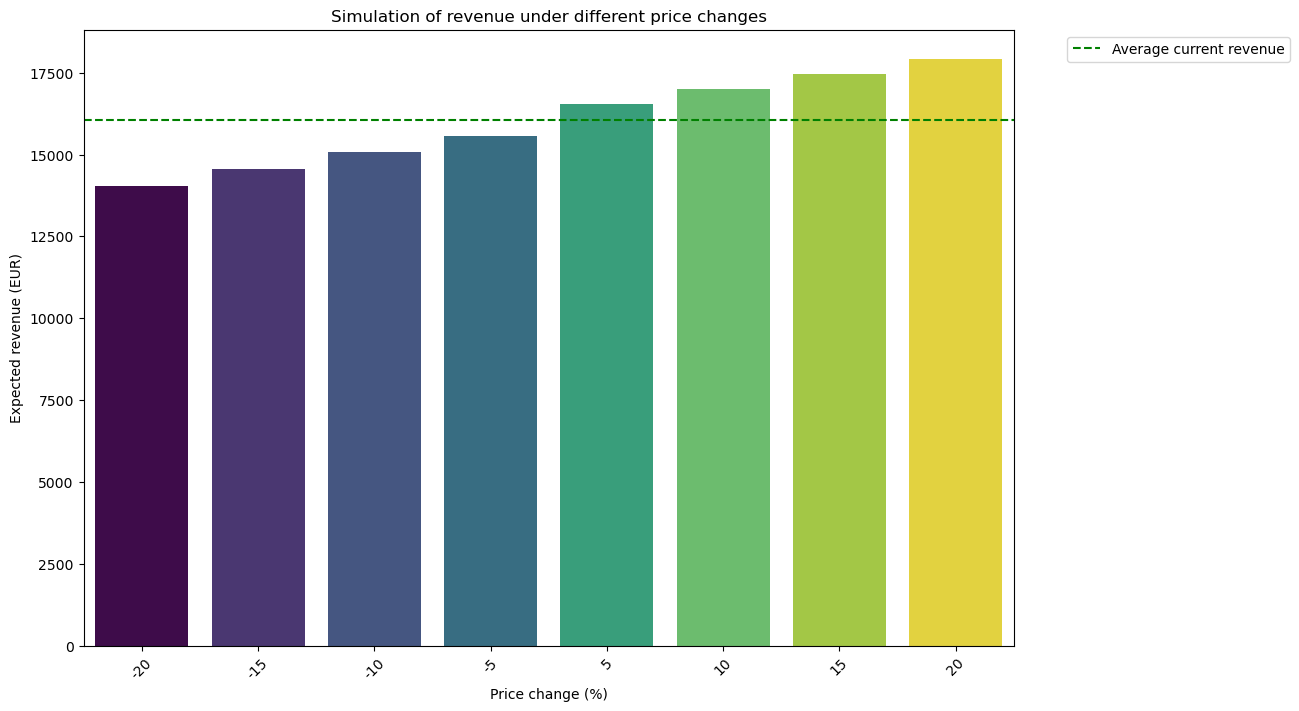

In [41]:
current_revenue = baseline_price * baseline_demand

plt.figure(figsize=(12, 8))
sns.barplot(x = 'price_change', y = 'expected_revenue', hue='price_change', data = simulation_results_df, palette = 'viridis', legend=False)
plt.title('Simulation of revenue under different price changes')
plt.xlabel('Price change (%)')
plt.ylabel('Expected revenue (EUR)')
plt.axhline(y = current_revenue, color = 'green', linestyle = '--', label='Average current revenue')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 2) Plot showing changes in the number of bookings

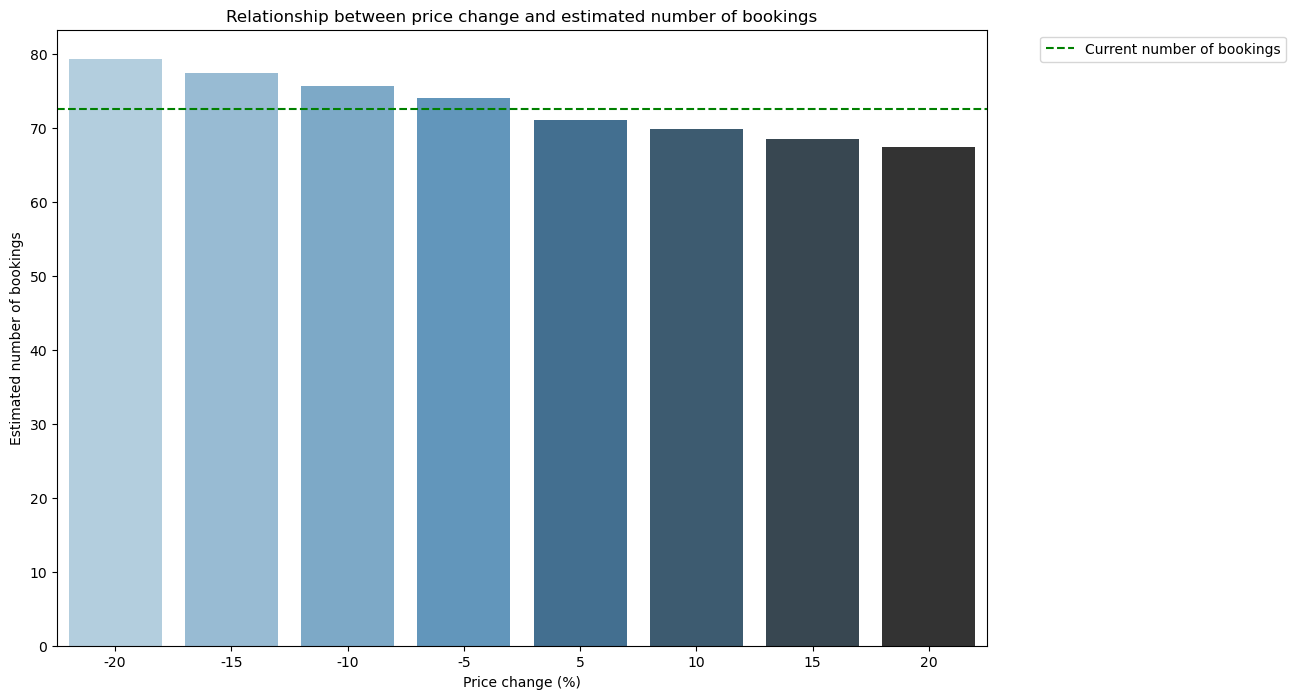

In [44]:
plt.figure(figsize=(12,8))
sns.barplot(x='price_change', y='estimated_bookings', hue='price_change', data=simulation_results_df, palette='Blues_d', legend=False)
plt.xlabel('Price change (%)')
plt.ylabel('Estimated number of bookings')
plt.title('Relationship between price change and estimated number of bookings')
plt.axhline(y=baseline_demand, color='green', linestyle='--', label='Current number of bookings')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Step 5: Conclusions and Recommendations

1. **Increase in bookings when prices are lowered:**  
   The simulation model shows that reducing the price by a given percentage leads to an increase in the estimated number of bookings, although the increase is not substantial. This means that lower prices attract more customers, but the growth does not exceed 10%.

2. **Higher revenue when prices are raised:**  
   A higher number of bookings does not translate into higher revenue. We observe that the client earns less when reducing rental prices, while the highest revenue is achieved when prices are increased by 20%. This indicates that demand in this case is relatively inelastic — the percentage decrease in bookings in response to a price increase is smaller than the percentage increase in price, resulting in higher revenue.

The client should consider a strategy of raising prices, because with inelastic demand, higher prices do not lead to a proportional drop in the number of bookings, ultimately increasing revenue.

However, it is important to take into account the impact of higher prices on competitiveness, customer satisfaction, and potential changes in demand behavior in the long term.


## Part II

After reviewing the results of the initial simulation, the client would also like to analyze how changes in rental prices affect revenue when taking property location into account.  
In Florence, Airbnb listings are distributed across five districts: **Campo di Marte**, **Centro Storico**, **Gavinana Galluzzo**, **Isolotto Legnaia**, and **Rifredi**.

The aim of this analysis is to determine the optimal rental prices that maximize both the number of bookings and total revenue, depending on the property's location.


## Step 1: Data preparation

In [50]:
# Creating a new DataFrame containing only the columns `id`, `price`, `number_of_reviews`, and `neighbourhood`
df2 = listings_df[['id', 'price', 'number_of_reviews', 'neighbourhood']]
df2

,id,price,number_of_reviews,neighbourhood
0,31840,103.0,148,Centro Storico
1,32180,148.0,38,Centro Storico
2,39115,53.0,83,Centro Storico
3,39165,70.0,23,Centro Storico
4,39822,82.0,32,Centro Storico
...,...,...,...,...
12472,1376118285054788791,80.0,0,Rifredi
12473,1376138873541795675,480.0,0,Centro Storico
12474,1376139147109182401,460.0,0,Centro Storico
12475,1376141473981854845,122.0,0,Centro Storico


## Step 2: Defining the simulation model and running the simulation

In [53]:
def simulate_price_changes_by_neighbourhood(df, price_change_percentages, elasticity=-0.4015):
    """
    A function that simulates changes in revenue resulting from price modifications,  
    taking into account both the division of listings by district and the price elasticity coefficient.

    Parameters:
      - df: DataFrame with the columns `price`, `number_of_reviews`, and `neighbourhood`
      - price_change_percentages: list of price changes expressed in percentages
      - elasticity: price elasticity coefficient

    Returns:
      - A list of dictionaries with the following keys:
          - `neighbourhood`: district name  
          - `baseline_price`: baseline price  
          - `price_change`: price change (%)  
          - `new_price`: new average price  
          - `estimated_bookings`: estimated number of bookings  
          - `expected_revenue`: expected revenue
     """
    results = []
    
    # Grouping data by district
    grouped = df.groupby('neighbourhood')
    
    for neighbourhood, group in grouped:
        # Baseline values for the given district
        baseline_price = group['price'].mean()
        baseline_demand = group['number_of_reviews'].mean()

        for change in price_change_percentages:
            # Calculating the new price for each listing in the group
            new_price_series = group['price'] * (1 + change / 100)
            avg_new_price = new_price_series.mean()

            if baseline_price == 0:
                estimated_bookings = 0
                expected_revenue = 0
            else:
                # Estimating the number of bookings
                estimated_bookings = baseline_demand * ((avg_new_price / baseline_price) ** elasticity)
                # Calculating revenue
                expected_revenue = avg_new_price * estimated_bookings

            results.append({
                'neighbourhood': neighbourhood,
                'baseline_price': baseline_price,
                'price_change': change,
                'new_price': avg_new_price,
                'estimated_bookings': estimated_bookings,
                'expected_revenue': expected_revenue
            })
    return results



In [55]:
simulation_results_by_neighbourhood = simulate_price_changes_by_neighbourhood(df2, price_change_percentages, elasticity=-0.4015)

In [57]:
simulation_results_by_neighbourhood_df = pd.DataFrame(simulation_results_by_neighbourhood)
simulation_results_by_neighbourhood_df

,neighbourhood,baseline_price,price_change,new_price,estimated_bookings,expected_revenue
0,Campo di Marte,221.962214,-20,177.569772,56.988401,10119.417388
1,Campo di Marte,221.962214,-15,188.667882,55.618005,10493.331163
2,Campo di Marte,221.962214,-10,199.765993,54.356156,10858.511459
3,Campo di Marte,221.962214,-5,210.864104,53.188908,11215.631452
4,Campo di Marte,221.962214,5,233.060325,51.093964,11907.975915
5,Campo di Marte,221.962214,10,244.158436,50.148499,12244.179117
6,Campo di Marte,221.962214,15,255.256547,49.261419,12574.299766
7,Campo di Marte,221.962214,20,266.354657,48.426807,12898.705520
8,Centro Storico,247.558472,-20,198.046777,89.013995,17628.934835
9,Centro Storico,247.558472,-15,210.424701,86.873481,18280.326245


## Step 2: Visualization

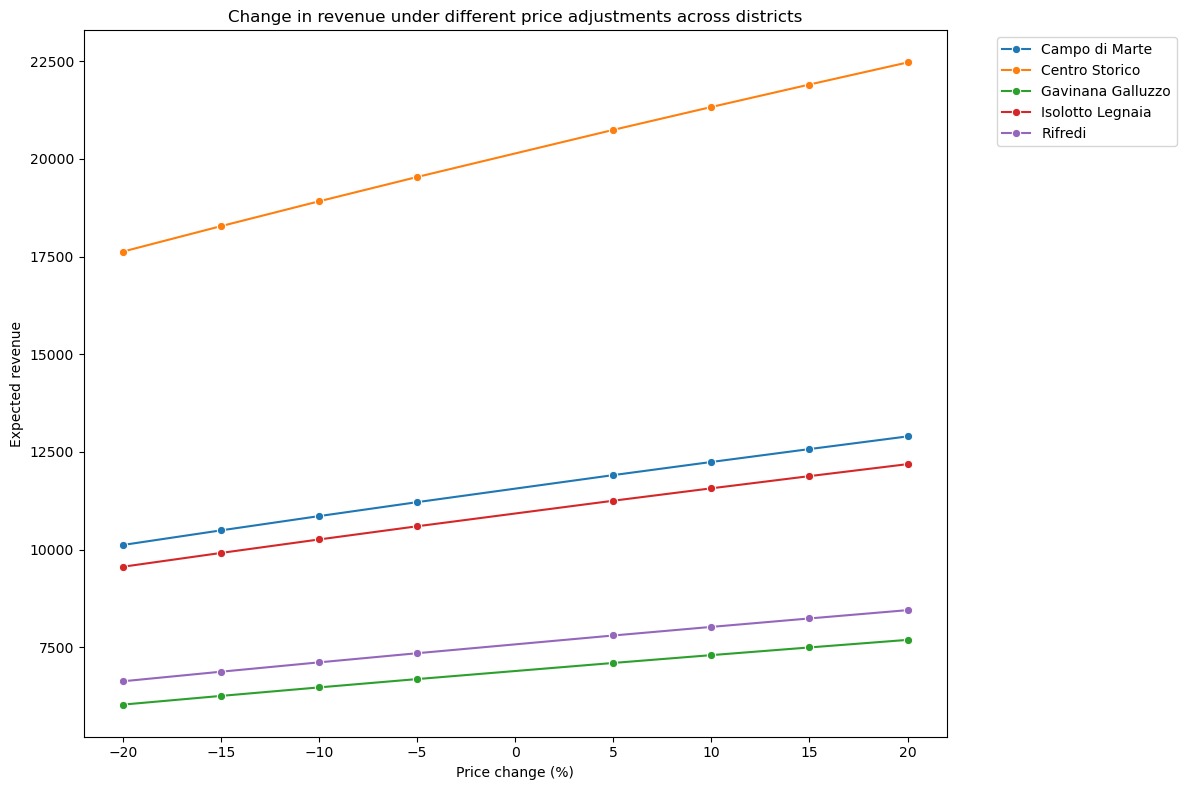

In [60]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=simulation_results_by_neighbourhood_df, 
             x='price_change', 
             y='expected_revenue', 
             hue='neighbourhood', 
             marker='o')

plt.xlabel('Price change (%)')
plt.ylabel('Expected revenue')
plt.title('Change in revenue under different price adjustments across districts')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 2) Plot showing changes in the number of bookings depending on price adjustments across districts

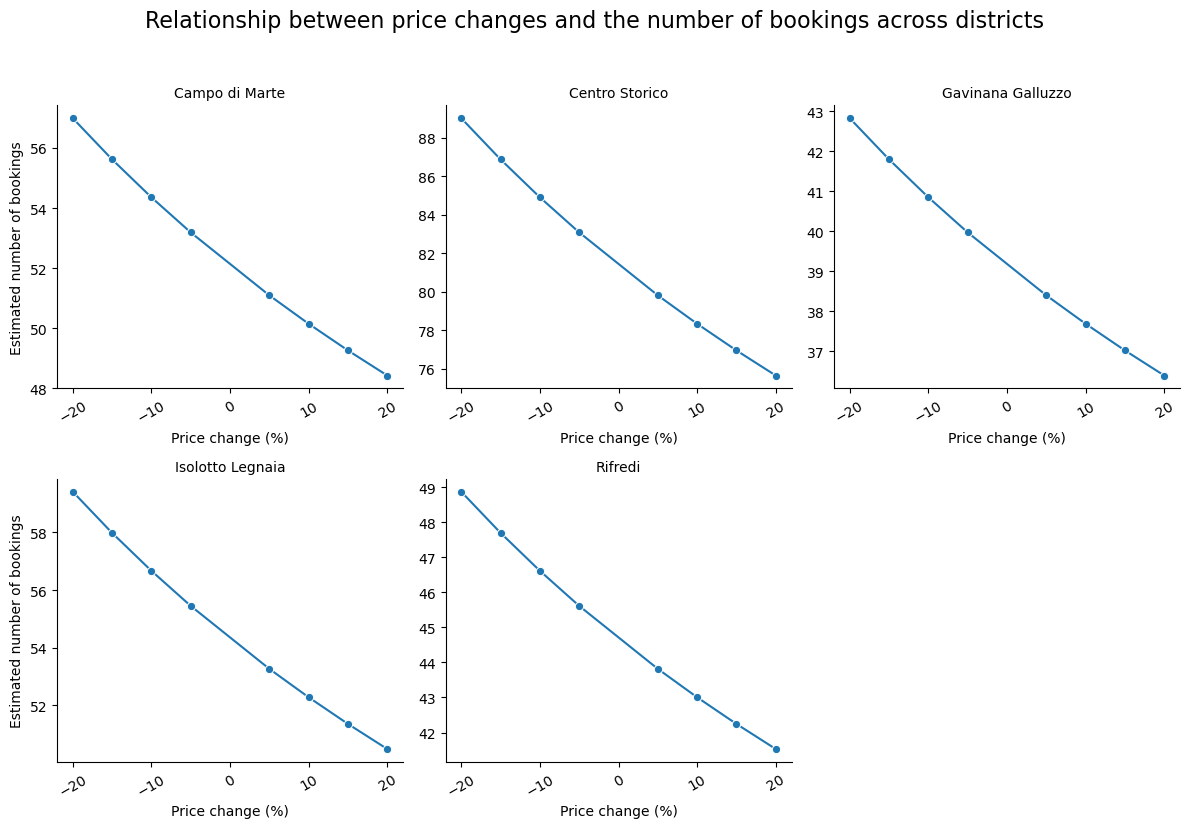

In [63]:
# Creating a grid of plots — one for each district
g = sns.FacetGrid(
    simulation_results_by_neighbourhood_df, 
    col="neighbourhood", 
    col_wrap=3, 
    height=4, 
    sharey=False,
    sharex=False
)

# Plotting the line for each district
g.map_dataframe(
    sns.lineplot, 
    x="price_change", 
    y="estimated_bookings", 
    marker="o"
)

# Labels and titles
g.set_axis_labels("Price change (%)", "Estimated number of bookings")
g.set_titles("{col_name}")
g.fig.suptitle("Relationship between price changes and the number of bookings across districts", fontsize=16, y=1.03)

for ax in g.axes.flat:
    # rotate tick labels
    for label in ax.get_xticklabels():
        label.set_rotation(30)

    # set x-axis label for each subplot
    ax.set_xlabel("Price change (%)")

    # ensure labels are visible
    ax.tick_params(labelbottom=True)

plt.tight_layout()
plt.show()

In [64]:
# Creating a table showing the optimal price change and maximum revenue for each district
summary_df = simulation_results_by_neighbourhood_df.loc[
    simulation_results_by_neighbourhood_df.groupby('neighbourhood')['expected_revenue'].idxmax()
][['neighbourhood', 'price_change', 'expected_revenue']].reset_index(drop=True)


summary_df.columns = ['District', 'Optimal price change (%)', 'Maximum revenue']

summary_df

,District,Optimal price change (%),Maximum revenue
0,Campo di Marte,20,12898.705520
1,Centro Storico,20,22470.704622
2,Gavinana Galluzzo,20,7690.301863
3,Isolotto Legnaia,20,12188.480847
4,Rifredi,20,8451.585062


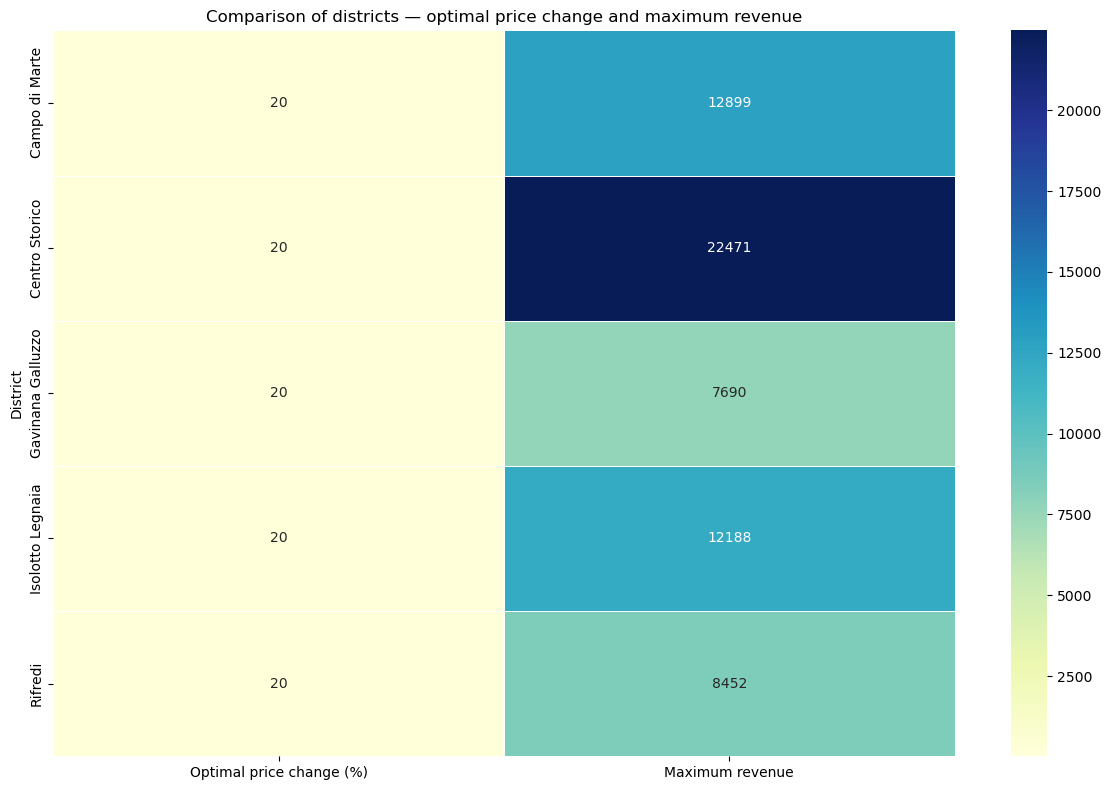

In [67]:
# Setting districts as the index
heatmap_data = summary_df.set_index('District')

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".0f", 
    cmap="YlGnBu", 
    linewidths=0.5,
    
)
plt.title("Comparison of districts — optimal price change and maximum revenue")
plt.tight_layout()
plt.show()

## Step 3: Conclusions

### In all districts, revenue decreases when prices are lowered  
The simulation results clearly show that lower prices are not compensated by an increase in the number of bookings — as a result, total revenue declines.  
This means that demand is **inelastic**: the number of bookings increases too weakly to offset the lower price.

### Most districts achieve the highest revenue with a 10–20% price increase  
This indicates that customers in these areas are willing to pay more, and the price increase does not significantly discourage them from making a reservation.

### The absence of an “optimal price decrease” suggests that current prices are relatively low  
Since lowering prices always reduces revenue, it can be inferred that the current price levels are not excessive. On the contrary — there is room to increase them.


## Part III

The goal of this part of the analysis is to determine how to optimize the short-term rental pricing strategy in Florence by simultaneously accounting for property location and seasonal fluctuations in demand, in order to maximize revenue throughout the year.

## Step 1: Loading data from file

In [73]:
reviews_df = pd.read_csv("reviews.csv")
reviews_df.head()

,listing_id,date
0,31840,2010-06-23
1,31840,2010-07-16
2,31840,2010-07-19
3,31840,2010-09-09
4,31840,2010-09-24


In [75]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904945 entries, 0 to 904944
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   listing_id  904945 non-null  int64 
 1   date        904945 non-null  object
dtypes: int64(1), object(1)
memory usage: 13.8+ MB


## Step 2: Data preparation


In [78]:
# Converting the `date` column from object to datetime
reviews_df['date'] = pd.to_datetime(reviews_df['date'], errors='coerce')
# Extracting the month from the date and adding it as a new column
reviews_df['month'] = reviews_df['date'].dt.month
reviews_df

,listing_id,date,month
0,31840,2010-06-23,6
1,31840,2010-07-16,7
2,31840,2010-07-19,7
3,31840,2010-09-09,9
4,31840,2010-09-24,9
...,...,...,...
904940,1362492002458499029,2025-03-06,3
904941,1362492002458499029,2025-03-08,3
904942,1362492002458499029,2025-03-09,3
904943,1362492002458499029,2025-03-14,3


In [80]:
# Counting the number of reviews for each `listing_id` and month
monthly_reviews = reviews_df.groupby(['listing_id', 'month']).size().reset_index(name='review_count')
monthly_reviews

,listing_id,month,review_count
0,31840,1,7
1,31840,2,13
2,31840,3,13
3,31840,4,11
4,31840,5,7
...,...,...,...
90293,1366047900692834481,3,1
90294,1366889495053067034,3,3
90295,1367353909763238769,3,1
90296,1369372841297486273,3,1


In [82]:
# Merging the DataFrames: `df2` and `monthly_reviews`
merged_df = monthly_reviews.merge(df2, left_on='listing_id', right_on='id', how='left')
merged_df

,listing_id,month,review_count,id,price,number_of_reviews,neighbourhood
0,31840,1,7,31840,103.0,148,Centro Storico
1,31840,2,13,31840,103.0,148,Centro Storico
2,31840,3,13,31840,103.0,148,Centro Storico
3,31840,4,11,31840,103.0,148,Centro Storico
4,31840,5,7,31840,103.0,148,Centro Storico
...,...,...,...,...,...,...,...
90293,1366047900692834481,3,1,1366047900692834481,194.0,1,Campo di Marte
90294,1366889495053067034,3,3,1366889495053067034,438.0,3,Centro Storico
90295,1367353909763238769,3,1,1367353909763238769,54.0,1,Centro Storico
90296,1369372841297486273,3,1,1369372841297486273,67.0,1,Centro Storico


## Step 3: Defining the simulation model and running the simulation

In [85]:
def simulate_price_changes_by_neighbourhood_and_month(df, price_change_percentages, elasticity=-0.4015):
    """
    The function simulates the impact of price changes on the number of bookings and revenue,
    broken down by district and month (seasonality).

    Parameters:
      - df: DataFrame with the columns `month`, `review_count`, `price`, `number_of_reviews`, `neighbourhood`
      - price_change_percentages: list of price changes
      - elasticity: price elasticity of demand

    Returns:
      - A list of dictionaries with the following keys:
        - `neighbourhood`: district name  
        - `month`: month number  
        - `price_change`: price change (%)  
        - `baseline_price`: baseline price  
        - `new_price`: new average price  
        - `estimated_bookings`: estimated number of bookings  
        - `expected_revenue`: expected revenue, calculated as `new_price * estimated_bookings`

    """
    results = []

    grouped = df.groupby(['neighbourhood', 'month'])

    for (neighbourhood, month), group in grouped:
       # Baseline values for each district and month
        baseline_price = group['price'].mean()
        baseline_demand = group['review_count'].sum()

        for change in price_change_percentages:
           # Calculating the new price for each listing in the group
            new_price_series = group['price'] * (1 + change / 100)
            avg_new_price = new_price_series.mean()

            
            # Estimating the number of bookings
            estimated_bookings = baseline_demand * ((avg_new_price / baseline_price) ** elasticity)
            # Calculating revenue
            expected_revenue = avg_new_price * estimated_bookings

            results.append({
                'neighbourhood': neighbourhood,
                'month': month,
                'price_change': change,
                'baseline_price': baseline_price,
                'new_price': avg_new_price,
                'estimated_bookings': estimated_bookings,
                'expected_revenue': expected_revenue
            })

    return results


In [87]:
simulation_results_by_neighbourhood_and_month = simulate_price_changes_by_neighbourhood_and_month(merged_df, 
                                                                                                  price_change_percentages, elasticity=-0.4015)

In [89]:
simulation_results_by_neighbourhood_and_month_df = pd.DataFrame(simulation_results_by_neighbourhood_and_month)
simulation_results_by_neighbourhood_and_month_df

,neighbourhood,month,price_change,baseline_price,new_price,estimated_bookings,expected_revenue
0,Campo di Marte,1,-20,134.807249,107.845799,3447.430972,371790.947708
1,Campo di Marte,1,-15,134.807249,114.586161,3364.530814,385528.671062
2,Campo di Marte,1,-10,134.807249,121.326524,3288.197095,398945.523355
3,Campo di Marte,1,-5,134.807249,128.066886,3217.586131,412066.237292
4,Campo di Marte,1,5,134.807249,141.547611,3090.855524,437503.215944
...,...,...,...,...,...,...,...
475,Rifredi,12,-5,103.383249,98.214086,1846.641279,181366.185921
476,Rifredi,12,5,103.383249,108.552411,1773.907881,192561.977718
477,Rifredi,12,10,103.383249,113.721574,1741.082714,197998.666028
478,Rifredi,12,15,103.383249,118.890736,1710.284595,203336.994350


## Step 4: Visualization

The two most profitable districts are **Campo di Marte** and **Centro Storico**.  
For simplicity, the visualizations will be prepared only for these two districts.

### Visualization for the Campo di Marte district


In [94]:
campo_df = simulation_results_by_neighbourhood_and_month_df[
    simulation_results_by_neighbourhood_and_month_df['neighbourhood'] == "Campo di Marte"
]
campo_df

,neighbourhood,month,price_change,baseline_price,new_price,estimated_bookings,expected_revenue
0,Campo di Marte,1,-20,134.807249,107.845799,3447.430972,371790.947708
1,Campo di Marte,1,-15,134.807249,114.586161,3364.530814,385528.671062
2,Campo di Marte,1,-10,134.807249,121.326524,3288.197095,398945.523355
3,Campo di Marte,1,-5,134.807249,128.066886,3217.586131,412066.237292
4,Campo di Marte,1,5,134.807249,141.547611,3090.855524,437503.215944
...,...,...,...,...,...,...,...
91,Campo di Marte,12,-5,126.707692,120.372308,2820.491904,339509.119263
92,Campo di Marte,12,5,126.707692,133.043077,2709.401590,360467.124160
93,Campo di Marte,12,10,126.707692,139.378462,2659.265638,370644.353451
94,Campo di Marte,12,15,126.707692,145.713846,2612.225725,380637.457390


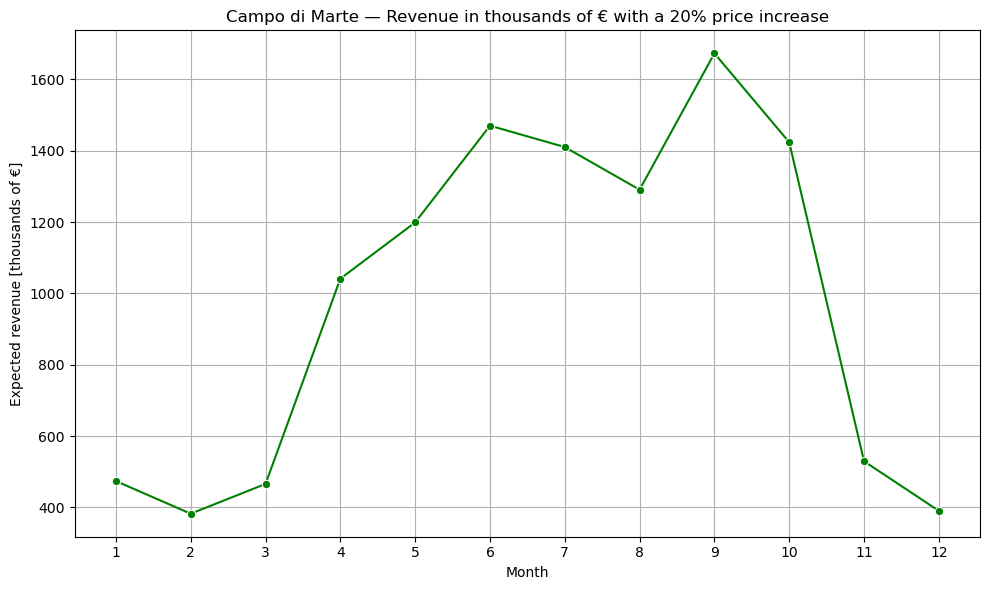

In [96]:
# Filtering data for the +20% price change scenario
campo_20_df = campo_df[campo_df['price_change'] == 20].copy()

# Converting revenue values to thousands of euros
campo_20_df.loc[:, 'expected_revenue_eur_k'] = campo_20_df['expected_revenue'] / 1000

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=campo_20_df,
    x="month",
    y="expected_revenue_eur_k",
    marker="o",
    color="green"
)
plt.title("Campo di Marte — Revenue in thousands of € with a 20% price increase")
plt.xlabel("Month")
plt.ylabel("Expected revenue [thousands of €]")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

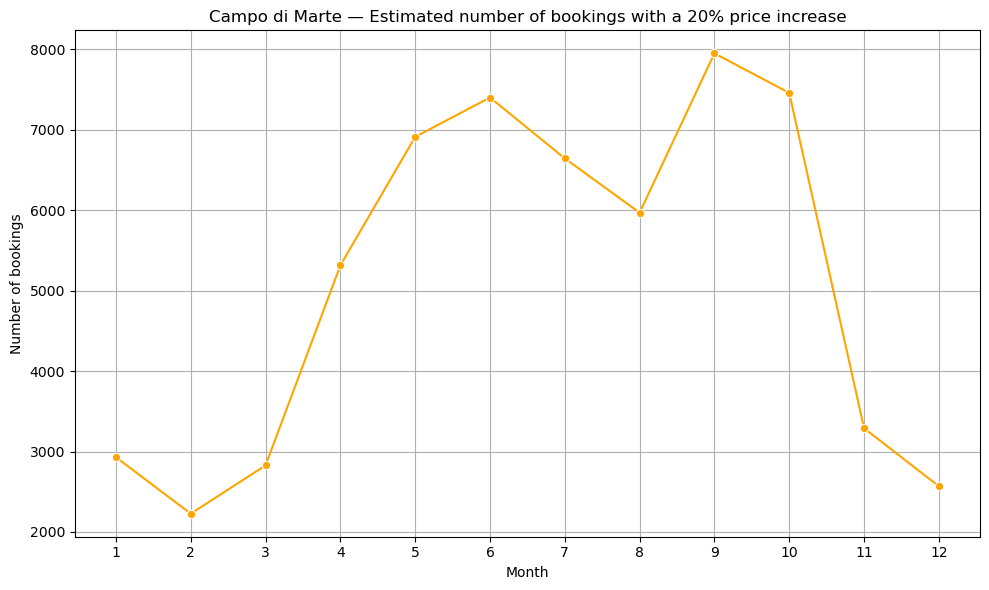

In [98]:
# Plot: number of bookings (`estimated_bookings`) across months
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=campo_20_df,
    x="month",
    y="estimated_bookings",
    marker="o",
    color="orange"
)


plt.title("Campo di Marte — Estimated number of bookings with a 20% price increase")
plt.xlabel("Month")
plt.ylabel("Number of bookings")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualization for the Centro Storico district


In [101]:
centro_df = simulation_results_by_neighbourhood_and_month_df[
    simulation_results_by_neighbourhood_and_month_df['neighbourhood'] == "Centro Storico"
]
centro_df

,neighbourhood,month,price_change,baseline_price,new_price,estimated_bookings,expected_revenue
96,Centro Storico,1,-20,194.835832,155.868666,44880.038865,6.995392e+06
97,Centro Storico,1,-15,194.835832,165.610457,43800.811366,7.253872e+06
98,Centro Storico,1,-10,194.835832,175.352249,42807.068396,7.506316e+06
99,Centro Storico,1,-5,194.835832,185.094040,41887.826555,7.753187e+06
100,Centro Storico,1,5,194.835832,204.577624,40237.996687,8.231794e+06
...,...,...,...,...,...,...,...
187,Centro Storico,12,-5,204.658913,194.425967,37245.192760,7.241433e+06
188,Centro Storico,12,5,204.658913,214.891859,35778.221648,7.688449e+06
189,Centro Storico,12,10,204.658913,225.124804,35116.165787,7.905520e+06
190,Centro Storico,12,15,204.658913,235.357750,34494.993774,8.118664e+06


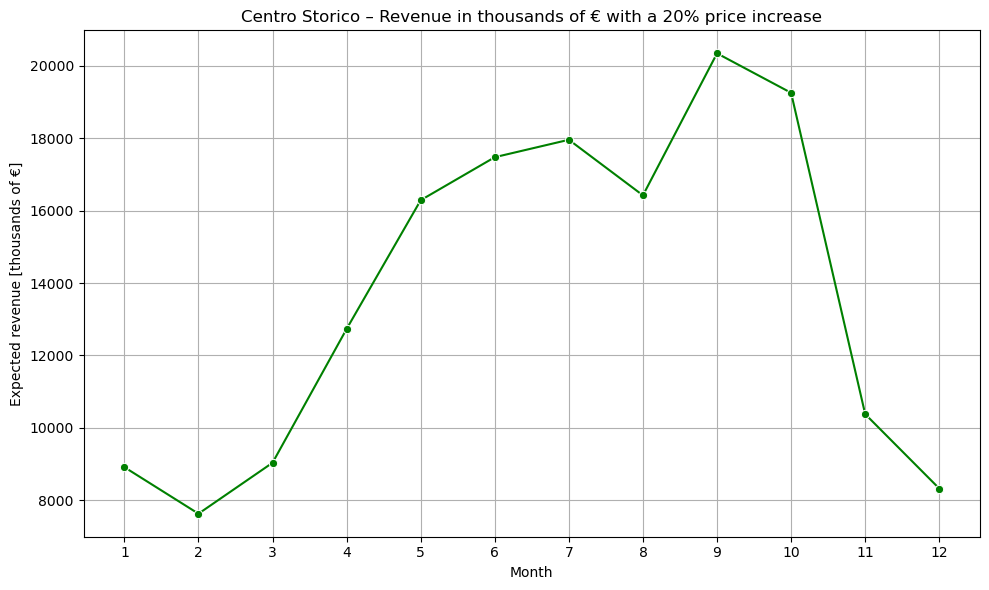

In [103]:
# Filtering data for the +20% price change scenario
centro_20_df = centro_df[centro_df['price_change'] == 20].copy()

# Converting revenue values to thousands of euros
centro_20_df.loc[:, 'expected_revenue_eur_k'] = centro_20_df['expected_revenue'] / 1000

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=centro_20_df,
    x="month",
    y="expected_revenue_eur_k",
    marker="o",
    color="green"
)
plt.title("Centro Storico – Revenue in thousands of € with a 20% price increase")
plt.xlabel("Month")
plt.ylabel("Expected revenue [thousands of €]")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

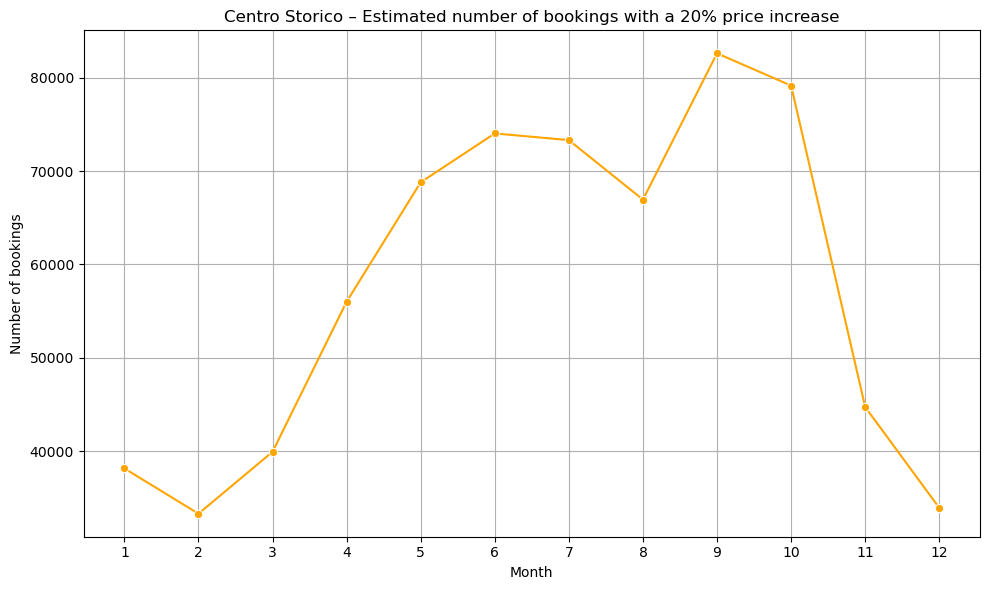

In [105]:
# Plot: number of bookings (`estimated_bookings`) across months
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=centro_20_df,
    x="month",
    y="estimated_bookings",
    marker="o",
    color="orange"
)


plt.title("Centro Storico – Estimated number of bookings with a 20% price increase")
plt.xlabel("Month")
plt.ylabel("Number of bookings")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary


The aim of this analysis was to determine the optimal pricing strategy for short-term rental properties in Florence.  
The analysis sought to answer the following question:

**Which price adjustments — decreases or increases — maximize the number of bookings and total revenue, taking into account price elasticity of demand, seasonality, and district-level differences?**


### Scope of the analysis:


1. Data preparation  
- The data comes from the Airbnb platform (`listings.csv`).  
- The analysis used the columns **`price`** and **`number_of_reviews`**.  
- Missing values in the `price` column were filled using the median.

2. Price elasticity modeling  
- A log–log regression model was applied to estimate the price elasticity coefficient.  
- The obtained elasticity value (**–0.4015**) indicates that a 1% increase in price leads to an average **0.40% decrease in the number of bookings**.

3. Simulation of price change scenarios  
- Simulations were conducted for price adjustments of **–20%, –15%, –10%, –5%, 5%, 10%, 15%, and 20%**.  
- The model incorporated both the change in average price and price elasticity.  
- Expected revenue was calculated as:  
  **new price × estimated number of bookings**.

4. Model enhancement  
- Seasonality (months) was included based on review data (`reviews.csv`).  
- The model was extended to include district-level segmentation, enabling analysis of local demand differences and revenue potential.


### Results of the analysis:


1. Increasing the price does not always lead to lower revenue — in many districts and months, higher prices generated higher revenue despite a decline in the number of bookings.

2. In districts such as **Centro Storico** and **Campo di Marte**, price increases of **10–20%** during the summer season were the most profitable.

3. Demand elasticity was moderate — customers respond to price changes, but not proportionally (a 10% change in price results in only about a 4% change in the number of bookings).
